In [60]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import norm, kstest
from statsmodels.tsa.seasonal import STL
from scipy import signal

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

# Filtering and trend extraction

In [75]:
test_file='C:/Users/Julia/Documents/ITMO/Statistical_data_analysis/Full_project/no_gaps_data/WI_Necedah_5_WNW.txt'
df=pd.read_csv(os.path.join(no_gaps_folder, test_file), sep=',')
df['LST_DATE'] = pd.to_datetime(df['LST_DATE'], format='%Y-%m-%d')
df

,LST_DATE,SUR_TEMP_DAILY_AVG,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,2016-01-01,-7.8,0.2,0.3,0.9,1.8,3.4
1,2016-01-02,-9.3,0.2,0.3,0.9,1.8,3.3
2,2016-01-03,-4.9,0.2,0.3,0.9,1.8,3.3
3,2016-01-04,-10.8,0.3,0.4,0.9,1.8,3.2
4,2016-01-05,-10.8,0.2,0.3,0.9,1.7,3.2
...,...,...,...,...,...,...,...
1766,2020-11-01,0.7,4.7,5.2,5.9,6.9,8.2
1767,2020-11-02,2.2,4.0,4.3,5.1,6.5,8.1
1768,2020-11-03,9.2,5.4,5.4,5.7,6.4,7.9
1769,2020-11-04,10.5,6.9,6.8,6.9,7.0,7.9


## Filtering with gauss core

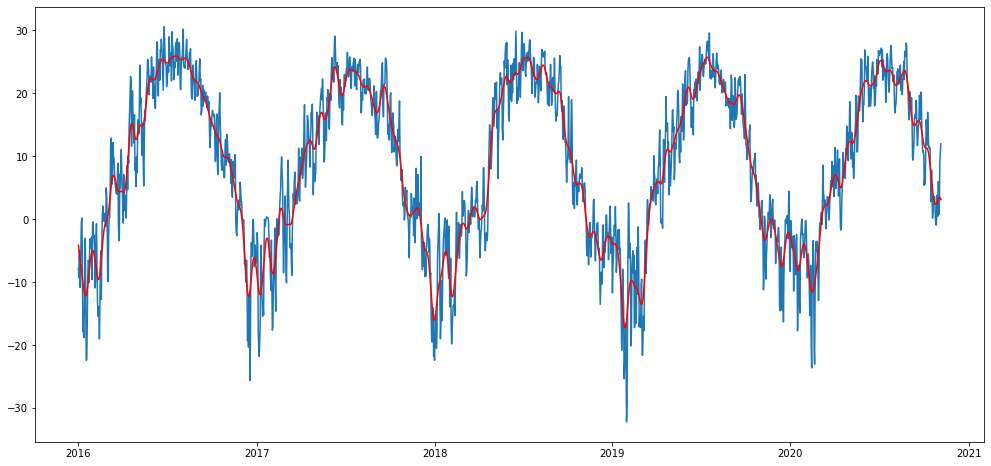

In [79]:
plt.rcParams['figure.figsize'] = [17, 8]

plt.plot(df['LST_DATE'], df['SUR_TEMP_DAILY_AVG'])

windows_size=25
gauss_sd=5
window = signal.gaussian(windows_size, gauss_sd)
output_gauss=signal.convolve(df['SUR_TEMP_DAILY_AVG'], window/window.sum(), mode='same')
df['gauss']=output_gauss
plt.plot(df['LST_DATE'], output_gauss, c='r')

## Comparing period and frequency before and after filtering

Text(0, 0.5, 'PSD [V**2/Hz]')

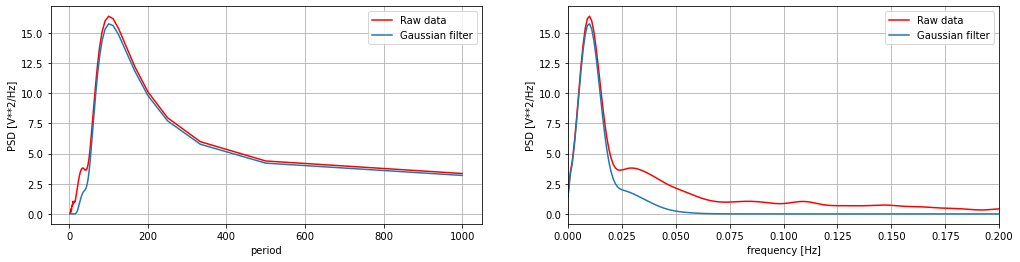

In [80]:
plt.rcParams['figure.figsize'] = [17, 4]

f, Pxx_den = signal.welch(output_gauss, fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
b_f, b_Pxx_den = signal.welch(df['SUR_TEMP_DAILY_AVG'], fs=1, scaling='spectrum', nfft = 1000, nperseg=100)

plt.subplot(1, 2, 1)
plt.plot(1/b_f, b_Pxx_den, c='r', label='Raw data')
plt.plot(1/f, Pxx_den, label='Gaussian filter')
plt.grid()

plt.legend()
plt.xlabel('period')
plt.ylabel('PSD [V**2/Hz]')

plt.subplot(1, 2, 2)
plt.plot(b_f, b_Pxx_den, c='r', label='Raw data')
plt.plot(f, Pxx_den, label='Gaussian filter' )
plt.xlim(0, 0.2)
plt.grid()
plt.legend()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

## Extracting trend, seasonarity and resid

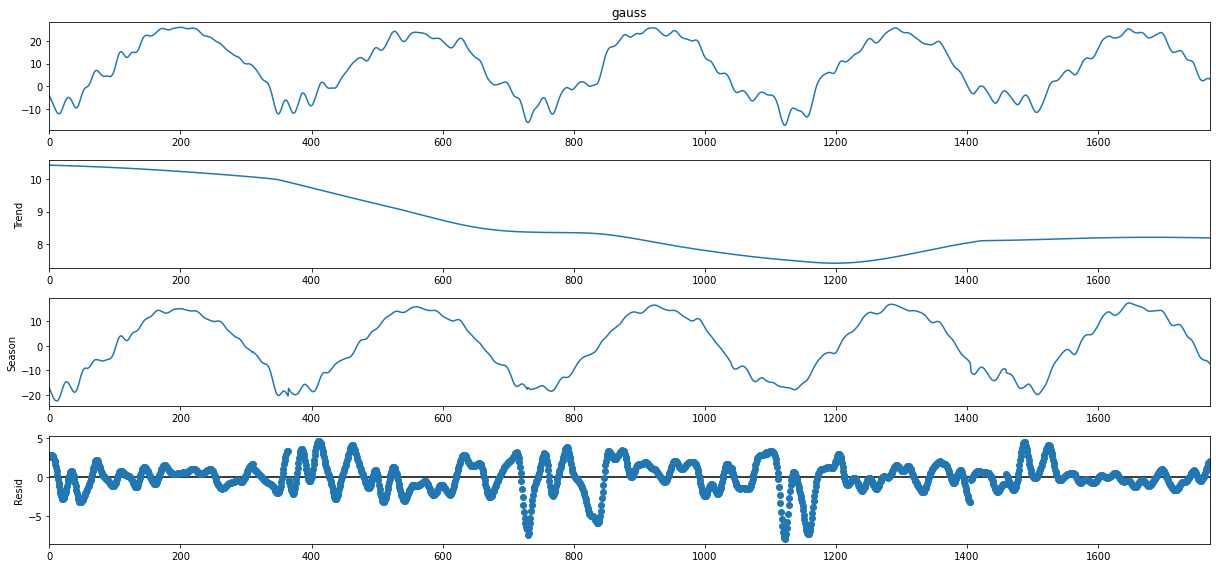

In [81]:
plt.rcParams['figure.figsize'] = [17, 8]
stl = STL(df['gauss'], period=365)
res = stl.fit()
fig = res.plot()

## Comparing resid destribution with normal

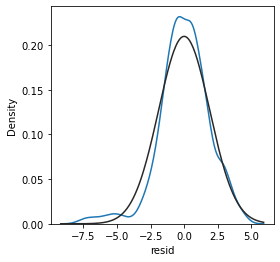

KstestResult(statistic=0.05628441894080402, pvalue=2.5630125968110414e-05)


In [83]:
plt.rcParams['figure.figsize'] = [4, 4]
sns.distplot(res.resid, fit=norm, hist=False)
plt.show()
params = norm.fit(res.resid)
ks = kstest(res.resid, 'norm', params, N=1000)
print(ks)

## Fitting model, predicting and validation

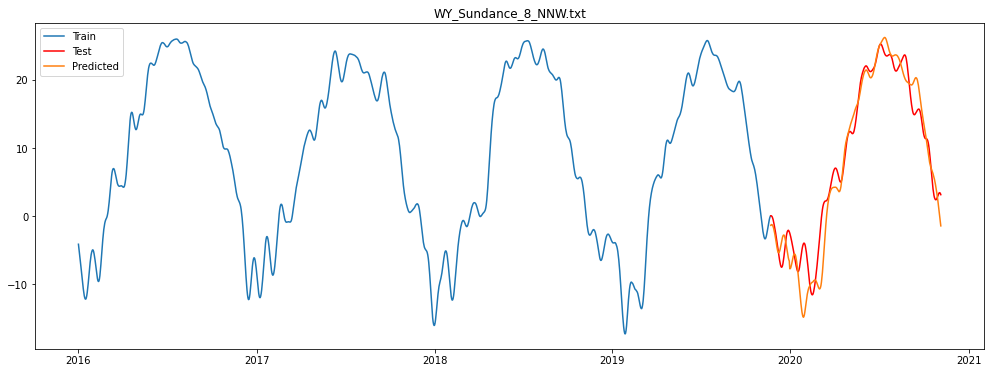

RMSE:
3.1098497802199154
MAE:
2.1781911091465136


In [88]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
plt.rcParams['figure.figsize'] = [17, 6]

test = df['gauss'][-350:]
test.index = df['LST_DATE'][-350:]
data = df['gauss'][:-350]
data.index = df['LST_DATE'][:-350]

stlf = STLForecast(data, ARIMA, period=365, model_kwargs={"order": (2, 1, 0)})
res = stlf.fit()
forecasts = res.forecast(350)
plt.rcParams['figure.figsize'] = [17, 6]
plt.plot(data, label='Train')
plt.plot(test, c='r', label='Test')
plt.plot(forecasts, label='Predicted')
plt.legend()
plt.title(file)
plt.show()

print('RMSE:')
print(sqrt(mean_squared_error(test, forecasts)))
print('MAE:')
print(mean_absolute_error(test, forecasts))


## Comparing model errors distribution with normal

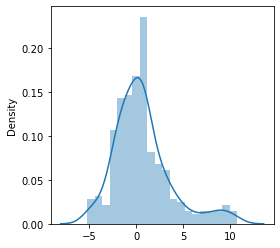

In [90]:
plt.rcParams['figure.figsize'] = [4, 4]
sns.distplot(test-forecasts)
plt.show()